In [1]:
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### Финальная модель: catboost на всех данных

In [2]:
#pip install catboost

In [2]:
from catboost import CatBoostClassifier
from catboost import Pool
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from matplotlib import pyplot as plt
import pickle

In [4]:
!nvidia-smi

Sun Jan  1 22:28:05 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 527.27       Driver Version: 527.27       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro P2000       WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   56C    P8    N/A /  N/A |      0MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
# from google.colab import drive
# drive.mount('/content/drive/')

In [3]:
#df = pd.read_csv('/content/drive/MyDrive/lenta_mystem_lemmas_str_largecol.csv')
df = pd.read_csv('lenta_mystem_lemmas_str_largecol_v02.csv')

In [4]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [5]:
df

,date,url,topic,tags,text_str,topic_le,title_lemmas,year,month,day,date_enc,season,day_of_week,dummy_weekday
0,1999-08-31,https://lenta.ru/news/1999/08/31/stancia_mir/,Россия,Все,становиться известно агентство ассошиэйтед пре...,20,космонавт сомневаться надежность мир,1999,8,31,0,3,1,1
1,1999-08-31,https://lenta.ru/news/1999/08/31/vzriv/,Россия,Все,зал игровой автомат третий ярус подземный комп...,20,взрыв центр москва пострадать человек,1999,8,31,0,3,1,1
2,1999-08-31,https://lenta.ru/news/1999/08/31/credit_japs/,Россия,Все,япония принимать решение размораживать кредит ...,20,япония кредитовать россия полтора миллиард доллар,1999,8,31,0,3,1,1
3,1999-08-31,https://lenta.ru/news/1999/08/31/diana/,Мир,Все,британец отмечать сегодня скорбный дата вторую...,13,британец отмечать двухлетие смерть диана,1999,8,31,0,3,1,1
4,1999-08-31,https://lenta.ru/news/1999/08/31/mvf/,Россия,Все,понедельник директор департамент внешний связь...,20,отмывать bank деньги иметь отношение мвф,1999,8,31,0,3,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1153089,2022-11-18,https://lenta.ru/news/2022/11/18/bezhh/,Мир,Общество,беженец украина избивать город кейзер американ...,13,беженец украина избивать спор нацист,2022,11,18,8472,4,4,1
1153090,2022-11-18,https://lenta.ru/news/2022/11/18/nurmagomedov/,Спорт,Бокс и ММА,российский боец смешанный стиль мма двоюродный...,23,брат нурмагомедов называть цель выступление be...,2022,11,18,8472,4,4,1
1153091,2022-11-18,https://lenta.ru/news/2022/11/18/bioprint/,Наука и техника,Будущее,ученый израильский технологический институт ра...,16,разрабатывать технология печать ткань транспла...,2022,11,18,8472,4,4,1
1153092,2022-11-18,https://lenta.ru/news/2022/11/18/penni/,Мир,Политика,республиканец палата представитель конгресс сш...,13,республиканец конгресс потребовать проверять к...,2022,11,18,8472,4,4,1


In [6]:
df.columns

Index(['date', 'url', 'topic', 'tags', 'text_str', 'topic_le', 'title_lemmas',
       'year', 'month', 'day', 'date_enc', 'season', 'day_of_week',
       'dummy_weekday'],
      dtype='object')

In [7]:
df['topic'].value_counts().index[-6:]

Index(['Библиотека', 'Оружие', 'ЧМ-2014', 'Мотор', 'МедНовости', 'Сочи'], dtype='object')

In [8]:
names = list(df['topic'].value_counts().index[-6:])
df = df[~df['topic'].isin(names)]

In [9]:
df['topic'].value_counts()

Россия               241055
Мир                  195778
Экономика            122120
Бывший СССР           93769
Спорт                 91267
Наука и техника       75609
Культура              71765
Интернет и СМИ        64800
Из жизни              44812
Силовые структуры     43287
Путешествия           22756
Ценности              22323
Дом                   22132
Среда обитания        15607
Бизнес                 7430
Моя страна             6128
Нацпроекты             4728
69-я параллель         3356
Забота о себе          3174
Крым                    666
Культпросвет            340
Легпром                 114
Name: topic, dtype: int64

In [10]:
dftrain, dftest, ytrain, ytest = train_test_split(df, df['topic_le'],
                                                  test_size=0.1,
                                                  stratify=df['topic'], 
                                                  random_state=123)

In [11]:
del df

In [12]:
dftrain.shape

(1037714, 14)

In [13]:
dftrain.columns

Index(['date', 'url', 'topic', 'tags', 'text_str', 'topic_le', 'title_lemmas',
       'year', 'month', 'day', 'date_enc', 'season', 'day_of_week',
       'dummy_weekday'],
      dtype='object')

In [14]:
#df_train = dftrain[['text_str', 'title_lemmas', 'year', 'month', 'day']]

text_cols = ['text_str', 'title_lemmas']
cat_cols = ['year', 'day_of_week', 'season']

In [15]:
clf = CatBoostClassifier(random_state=123, 
                         loss_function='MultiClass', 
                         eval_metric='TotalF1', 
                         task_type='GPU',                         
                         n_estimators=1600,
                         #learning_rate=0.2,
                         depth=9)
                         #max_ctr_complexity=2)

In [16]:
clf.fit(dftrain[['text_str', 'title_lemmas', 'date_enc', 'year', 'season', 'day_of_week']],
        ytrain,
        text_features=text_cols,
        cat_features=cat_cols)

Learning rate set to 0.180939
0:	learn: 0.6826842	total: 2.83s	remaining: 1h 15m 34s
1:	learn: 0.7430462	total: 5.53s	remaining: 1h 13m 37s
2:	learn: 0.7461593	total: 8.2s	remaining: 1h 12m 44s
3:	learn: 0.7624147	total: 11s	remaining: 1h 12m 49s
4:	learn: 0.7647648	total: 14.4s	remaining: 1h 16m 47s
5:	learn: 0.7663216	total: 17.6s	remaining: 1h 18m 8s
6:	learn: 0.7730102	total: 20.5s	remaining: 1h 17m 41s
7:	learn: 0.7786097	total: 23.2s	remaining: 1h 16m 53s
8:	learn: 0.7811867	total: 26.3s	remaining: 1h 17m 26s
9:	learn: 0.7825404	total: 29.1s	remaining: 1h 17m 12s
10:	learn: 0.7858643	total: 32s	remaining: 1h 17m 5s
11:	learn: 0.7885237	total: 34.7s	remaining: 1h 16m 29s
12:	learn: 0.7948472	total: 36.8s	remaining: 1h 14m 51s
13:	learn: 0.7960232	total: 39.3s	remaining: 1h 14m 12s
14:	learn: 0.7979081	total: 41.5s	remaining: 1h 13m 4s
15:	learn: 0.7997260	total: 44.1s	remaining: 1h 12m 48s
16:	learn: 0.8008197	total: 46.4s	remaining: 1h 12m
17:	learn: 0.8020773	total: 49.7s	remain

149:	learn: 0.8537614	total: 5m 53s	remaining: 56m 54s
150:	learn: 0.8539127	total: 5m 55s	remaining: 56m 48s
151:	learn: 0.8541099	total: 5m 57s	remaining: 56m 47s
152:	learn: 0.8542794	total: 5m 59s	remaining: 56m 44s
153:	learn: 0.8545898	total: 6m 2s	remaining: 56m 45s
154:	learn: 0.8546893	total: 6m 4s	remaining: 56m 39s
155:	learn: 0.8548756	total: 6m 6s	remaining: 56m 33s
156:	learn: 0.8549912	total: 6m 8s	remaining: 56m 26s
157:	learn: 0.8552146	total: 6m 10s	remaining: 56m 23s
158:	learn: 0.8552564	total: 6m 12s	remaining: 56m 20s
159:	learn: 0.8554534	total: 6m 15s	remaining: 56m 20s
160:	learn: 0.8556749	total: 6m 17s	remaining: 56m 18s
161:	learn: 0.8558763	total: 6m 19s	remaining: 56m 12s
162:	learn: 0.8561091	total: 6m 22s	remaining: 56m 12s
163:	learn: 0.8562821	total: 6m 25s	remaining: 56m 12s
164:	learn: 0.8564896	total: 6m 27s	remaining: 56m 13s
165:	learn: 0.8566868	total: 6m 30s	remaining: 56m 16s
166:	learn: 0.8567715	total: 6m 32s	remaining: 56m 10s
167:	learn: 0.

299:	learn: 0.8731878	total: 11m 31s	remaining: 49m 57s
300:	learn: 0.8733021	total: 11m 33s	remaining: 49m 54s
301:	learn: 0.8734151	total: 11m 36s	remaining: 49m 52s
302:	learn: 0.8734981	total: 11m 38s	remaining: 49m 49s
303:	learn: 0.8735812	total: 11m 40s	remaining: 49m 46s
304:	learn: 0.8736354	total: 11m 42s	remaining: 49m 43s
305:	learn: 0.8738460	total: 11m 45s	remaining: 49m 43s
306:	learn: 0.8739254	total: 11m 47s	remaining: 49m 40s
307:	learn: 0.8739701	total: 11m 50s	remaining: 49m 38s
308:	learn: 0.8740612	total: 11m 52s	remaining: 49m 35s
309:	learn: 0.8741319	total: 11m 54s	remaining: 49m 32s
310:	learn: 0.8741767	total: 11m 56s	remaining: 49m 29s
311:	learn: 0.8743239	total: 11m 58s	remaining: 49m 27s
312:	learn: 0.8743516	total: 12m	remaining: 49m 24s
313:	learn: 0.8744620	total: 12m 3s	remaining: 49m 22s
314:	learn: 0.8745209	total: 12m 5s	remaining: 49m 19s
315:	learn: 0.8746853	total: 12m 8s	remaining: 49m 18s
316:	learn: 0.8747959	total: 12m 10s	remaining: 49m 15s

447:	learn: 0.8849974	total: 17m	remaining: 43m 44s
448:	learn: 0.8850787	total: 17m 3s	remaining: 43m 42s
449:	learn: 0.8851412	total: 17m 5s	remaining: 43m 39s
450:	learn: 0.8852083	total: 17m 6s	remaining: 43m 36s
451:	learn: 0.8853032	total: 17m 9s	remaining: 43m 34s
452:	learn: 0.8853856	total: 17m 11s	remaining: 43m 31s
453:	learn: 0.8854683	total: 17m 13s	remaining: 43m 29s
454:	learn: 0.8855078	total: 17m 16s	remaining: 43m 27s
455:	learn: 0.8856423	total: 17m 18s	remaining: 43m 25s
456:	learn: 0.8856631	total: 17m 20s	remaining: 43m 22s
457:	learn: 0.8857283	total: 17m 22s	remaining: 43m 19s
458:	learn: 0.8858375	total: 17m 25s	remaining: 43m 17s
459:	learn: 0.8858939	total: 17m 27s	remaining: 43m 16s
460:	learn: 0.8860026	total: 17m 29s	remaining: 43m 13s
461:	learn: 0.8860952	total: 17m 31s	remaining: 43m 10s
462:	learn: 0.8861589	total: 17m 33s	remaining: 43m 7s
463:	learn: 0.8862557	total: 17m 35s	remaining: 43m 4s
464:	learn: 0.8862870	total: 17m 38s	remaining: 43m 2s
465

595:	learn: 0.8935480	total: 22m 27s	remaining: 37m 49s
596:	learn: 0.8936163	total: 22m 29s	remaining: 37m 47s
597:	learn: 0.8936885	total: 22m 32s	remaining: 37m 45s
598:	learn: 0.8937393	total: 22m 34s	remaining: 37m 42s
599:	learn: 0.8937598	total: 22m 36s	remaining: 37m 40s
600:	learn: 0.8938001	total: 22m 38s	remaining: 37m 37s
601:	learn: 0.8938424	total: 22m 40s	remaining: 37m 35s
602:	learn: 0.8938879	total: 22m 42s	remaining: 37m 32s
603:	learn: 0.8939486	total: 22m 44s	remaining: 37m 30s
604:	learn: 0.8940045	total: 22m 47s	remaining: 37m 28s
605:	learn: 0.8940470	total: 22m 48s	remaining: 37m 25s
606:	learn: 0.8940966	total: 22m 51s	remaining: 37m 22s
607:	learn: 0.8941760	total: 22m 53s	remaining: 37m 20s
608:	learn: 0.8942265	total: 22m 55s	remaining: 37m 18s
609:	learn: 0.8942624	total: 22m 57s	remaining: 37m 16s
610:	learn: 0.8942852	total: 22m 59s	remaining: 37m 13s
611:	learn: 0.8943072	total: 23m 1s	remaining: 37m 9s
612:	learn: 0.8943527	total: 23m 3s	remaining: 37m

743:	learn: 0.9005682	total: 27m 47s	remaining: 31m 58s
744:	learn: 0.9005974	total: 27m 49s	remaining: 31m 55s
745:	learn: 0.9006093	total: 27m 51s	remaining: 31m 53s
746:	learn: 0.9006315	total: 27m 53s	remaining: 31m 50s
747:	learn: 0.9006962	total: 27m 55s	remaining: 31m 48s
748:	learn: 0.9007149	total: 27m 57s	remaining: 31m 46s
749:	learn: 0.9007442	total: 27m 59s	remaining: 31m 43s
750:	learn: 0.9007871	total: 28m 2s	remaining: 31m 41s
751:	learn: 0.9008328	total: 28m 4s	remaining: 31m 39s
752:	learn: 0.9009034	total: 28m 6s	remaining: 31m 37s
753:	learn: 0.9009584	total: 28m 8s	remaining: 31m 35s
754:	learn: 0.9009912	total: 28m 10s	remaining: 31m 32s
755:	learn: 0.9010486	total: 28m 12s	remaining: 31m 29s
756:	learn: 0.9010620	total: 28m 14s	remaining: 31m 27s
757:	learn: 0.9010721	total: 28m 16s	remaining: 31m 24s
758:	learn: 0.9010992	total: 28m 18s	remaining: 31m 22s
759:	learn: 0.9011670	total: 28m 20s	remaining: 31m 19s
760:	learn: 0.9012371	total: 28m 23s	remaining: 31m 

891:	learn: 0.9059393	total: 32m 53s	remaining: 26m 6s
892:	learn: 0.9059457	total: 32m 55s	remaining: 26m 4s
893:	learn: 0.9060034	total: 32m 57s	remaining: 26m 1s
894:	learn: 0.9060003	total: 32m 59s	remaining: 25m 59s
895:	learn: 0.9060432	total: 33m 1s	remaining: 25m 56s
896:	learn: 0.9061221	total: 33m 3s	remaining: 25m 54s
897:	learn: 0.9061335	total: 33m 5s	remaining: 25m 52s
898:	learn: 0.9061652	total: 33m 7s	remaining: 25m 49s
899:	learn: 0.9061739	total: 33m 9s	remaining: 25m 47s
900:	learn: 0.9062690	total: 33m 11s	remaining: 25m 45s
901:	learn: 0.9062776	total: 33m 13s	remaining: 25m 42s
902:	learn: 0.9063329	total: 33m 15s	remaining: 25m 40s
903:	learn: 0.9063301	total: 33m 17s	remaining: 25m 38s
904:	learn: 0.9063401	total: 33m 19s	remaining: 25m 35s
905:	learn: 0.9063664	total: 33m 21s	remaining: 25m 33s
906:	learn: 0.9064294	total: 33m 24s	remaining: 25m 31s
907:	learn: 0.9064585	total: 33m 25s	remaining: 25m 28s
908:	learn: 0.9064839	total: 33m 28s	remaining: 25m 26s


1038:	learn: 0.9102713	total: 37m 52s	remaining: 20m 27s
1039:	learn: 0.9103048	total: 37m 54s	remaining: 20m 24s
1040:	learn: 0.9103533	total: 37m 57s	remaining: 20m 23s
1041:	learn: 0.9103788	total: 38m	remaining: 20m 21s
1042:	learn: 0.9103983	total: 38m 1s	remaining: 20m 18s
1043:	learn: 0.9104229	total: 38m 3s	remaining: 20m 16s
1044:	learn: 0.9104781	total: 38m 5s	remaining: 20m 14s
1045:	learn: 0.9104941	total: 38m 8s	remaining: 20m 11s
1046:	learn: 0.9105384	total: 38m 10s	remaining: 20m 9s
1047:	learn: 0.9105691	total: 38m 11s	remaining: 20m 7s
1048:	learn: 0.9105575	total: 38m 13s	remaining: 20m 4s
1049:	learn: 0.9106401	total: 38m 16s	remaining: 20m 2s
1050:	learn: 0.9106450	total: 38m 17s	remaining: 20m
1051:	learn: 0.9106531	total: 38m 19s	remaining: 19m 57s
1052:	learn: 0.9106853	total: 38m 21s	remaining: 19m 55s
1053:	learn: 0.9107237	total: 38m 23s	remaining: 19m 53s
1054:	learn: 0.9107394	total: 38m 25s	remaining: 19m 51s
1055:	learn: 0.9108018	total: 38m 28s	remaining

1183:	learn: 0.9141925	total: 42m 46s	remaining: 15m 1s
1184:	learn: 0.9141915	total: 42m 48s	remaining: 14m 59s
1185:	learn: 0.9142252	total: 42m 50s	remaining: 14m 57s
1186:	learn: 0.9142292	total: 42m 51s	remaining: 14m 54s
1187:	learn: 0.9142759	total: 42m 54s	remaining: 14m 52s
1188:	learn: 0.9143192	total: 42m 56s	remaining: 14m 50s
1189:	learn: 0.9143376	total: 42m 58s	remaining: 14m 48s
1190:	learn: 0.9143923	total: 42m 59s	remaining: 14m 45s
1191:	learn: 0.9143979	total: 43m 1s	remaining: 14m 43s
1192:	learn: 0.9144097	total: 43m 3s	remaining: 14m 41s
1193:	learn: 0.9144549	total: 43m 5s	remaining: 14m 39s
1194:	learn: 0.9144855	total: 43m 7s	remaining: 14m 36s
1195:	learn: 0.9145210	total: 43m 9s	remaining: 14m 34s
1196:	learn: 0.9145206	total: 43m 10s	remaining: 14m 32s
1197:	learn: 0.9145581	total: 43m 12s	remaining: 14m 30s
1198:	learn: 0.9145984	total: 43m 14s	remaining: 14m 27s
1199:	learn: 0.9146273	total: 43m 16s	remaining: 14m 25s
1200:	learn: 0.9146426	total: 43m 18s

1329:	learn: 0.9175388	total: 47m 30s	remaining: 9m 38s
1330:	learn: 0.9175896	total: 47m 32s	remaining: 9m 36s
1331:	learn: 0.9176121	total: 47m 33s	remaining: 9m 34s
1332:	learn: 0.9176249	total: 47m 36s	remaining: 9m 32s
1333:	learn: 0.9176745	total: 47m 38s	remaining: 9m 29s
1334:	learn: 0.9176959	total: 47m 40s	remaining: 9m 27s
1335:	learn: 0.9177239	total: 47m 42s	remaining: 9m 25s
1336:	learn: 0.9177393	total: 47m 44s	remaining: 9m 23s
1337:	learn: 0.9177463	total: 47m 46s	remaining: 9m 21s
1338:	learn: 0.9177670	total: 47m 48s	remaining: 9m 19s
1339:	learn: 0.9177718	total: 47m 50s	remaining: 9m 16s
1340:	learn: 0.9177814	total: 47m 51s	remaining: 9m 14s
1341:	learn: 0.9178055	total: 47m 53s	remaining: 9m 12s
1342:	learn: 0.9178121	total: 47m 55s	remaining: 9m 10s
1343:	learn: 0.9178472	total: 47m 57s	remaining: 9m 8s
1344:	learn: 0.9178655	total: 47m 59s	remaining: 9m 5s
1345:	learn: 0.9178916	total: 48m	remaining: 9m 3s
1346:	learn: 0.9179021	total: 48m 2s	remaining: 9m 1s
1

1477:	learn: 0.9204814	total: 52m 13s	remaining: 4m 18s
1478:	learn: 0.9204967	total: 52m 15s	remaining: 4m 16s
1479:	learn: 0.9205121	total: 52m 17s	remaining: 4m 14s
1480:	learn: 0.9205599	total: 52m 19s	remaining: 4m 12s
1481:	learn: 0.9205996	total: 52m 21s	remaining: 4m 10s
1482:	learn: 0.9206360	total: 52m 23s	remaining: 4m 8s
1483:	learn: 0.9206376	total: 52m 25s	remaining: 4m 5s
1484:	learn: 0.9206518	total: 52m 27s	remaining: 4m 3s
1485:	learn: 0.9206715	total: 52m 30s	remaining: 4m 1s
1486:	learn: 0.9207363	total: 52m 32s	remaining: 3m 59s
1487:	learn: 0.9207706	total: 52m 34s	remaining: 3m 57s
1488:	learn: 0.9208008	total: 52m 37s	remaining: 3m 55s
1489:	learn: 0.9208210	total: 52m 38s	remaining: 3m 53s
1490:	learn: 0.9208298	total: 52m 40s	remaining: 3m 51s
1491:	learn: 0.9208314	total: 52m 42s	remaining: 3m 48s
1492:	learn: 0.9208202	total: 52m 44s	remaining: 3m 46s
1493:	learn: 0.9208365	total: 52m 45s	remaining: 3m 44s
1494:	learn: 0.9208502	total: 52m 47s	remaining: 3m 

Сохраним модель в pickle

In [20]:
pkl_filename = "pickle_model_catboost_final_gpu90%.pkl" 
with open(pkl_filename, 'wb') as file: 
    pickle.dump(clf, file) 

Посмотрим на качество модели

In [17]:
def plot_feature_importance(importance,names,model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    plt.savefig('Catboost_feature_importance.png', bbox_inches='tight')

In [18]:
dict_topic = dict(zip(dftrain.topic, dftrain.topic_le))
dict_topic = dict(sorted(dict_topic.items(), key=lambda item: item[1]))

In [19]:
y_pred1 = clf.predict(dftest[['text_str', 'title_lemmas', 'date_enc', 'year', 'season', 'day_of_week']])

print(classification_report(ytest, y_pred1, target_names=dict_topic))
f1_score(ytest, y_pred1, average='micro')

                   precision    recall  f1-score   support

   69-я параллель       0.89      0.72      0.80       336
           Бизнес       0.79      0.76      0.78       743
      Бывший СССР       0.89      0.92      0.90      9377
              Дом       0.90      0.87      0.89      2213
    Забота о себе       0.90      0.92      0.91       317
         Из жизни       0.82      0.77      0.79      4481
   Интернет и СМИ       0.83      0.82      0.82      6480
             Крым       0.90      0.52      0.66        67
    Культпросвет        0.71      0.29      0.42        34
         Культура       0.90      0.93      0.91      7176
          Легпром       0.75      0.27      0.40        11
              Мир       0.87      0.88      0.88     19578
       Моя страна       0.93      0.91      0.92       613
  Наука и техника       0.91      0.91      0.91      7561
       Нацпроекты       0.95      0.94      0.94       473
      Путешествия       0.90      0.89      0.90      2

0.88716587743491

In [20]:
f1 = f1_score(ytest, y_pred1, average='micro')
print(f'F1-score by Catboost (1600 trees, trees depth - 9) is {f1}')

F1-score by Catboost (1600 trees, trees depth - 9) is 0.88716587743491


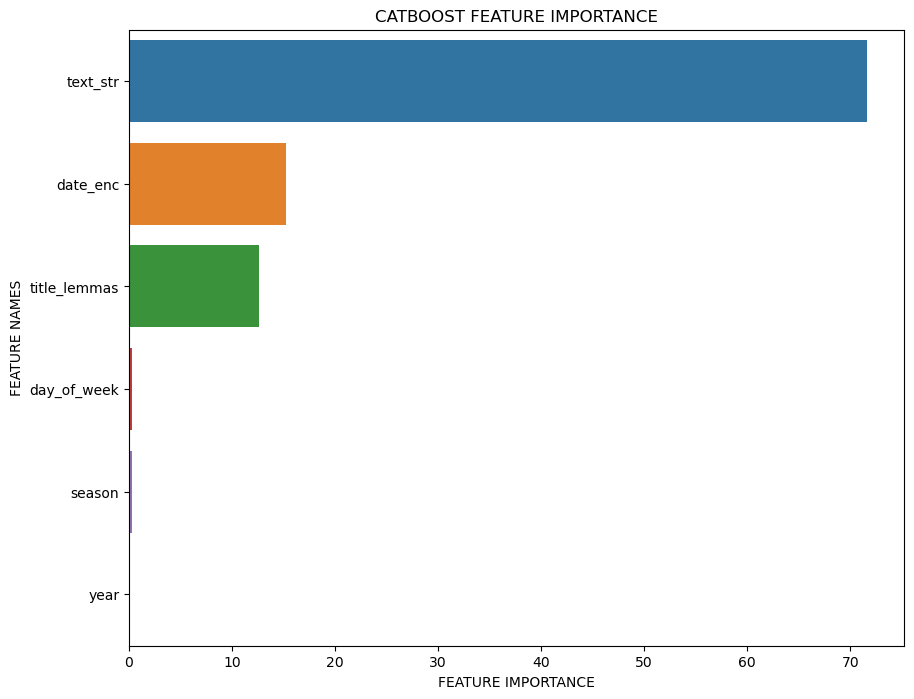

In [21]:
#plot the catboost result
plot_feature_importance(clf.get_feature_importance(),
                        ['text_str', 'title_lemmas', 'date_enc', 'year', 'season', 'day_of_week'],
                        'CATBOOST ')